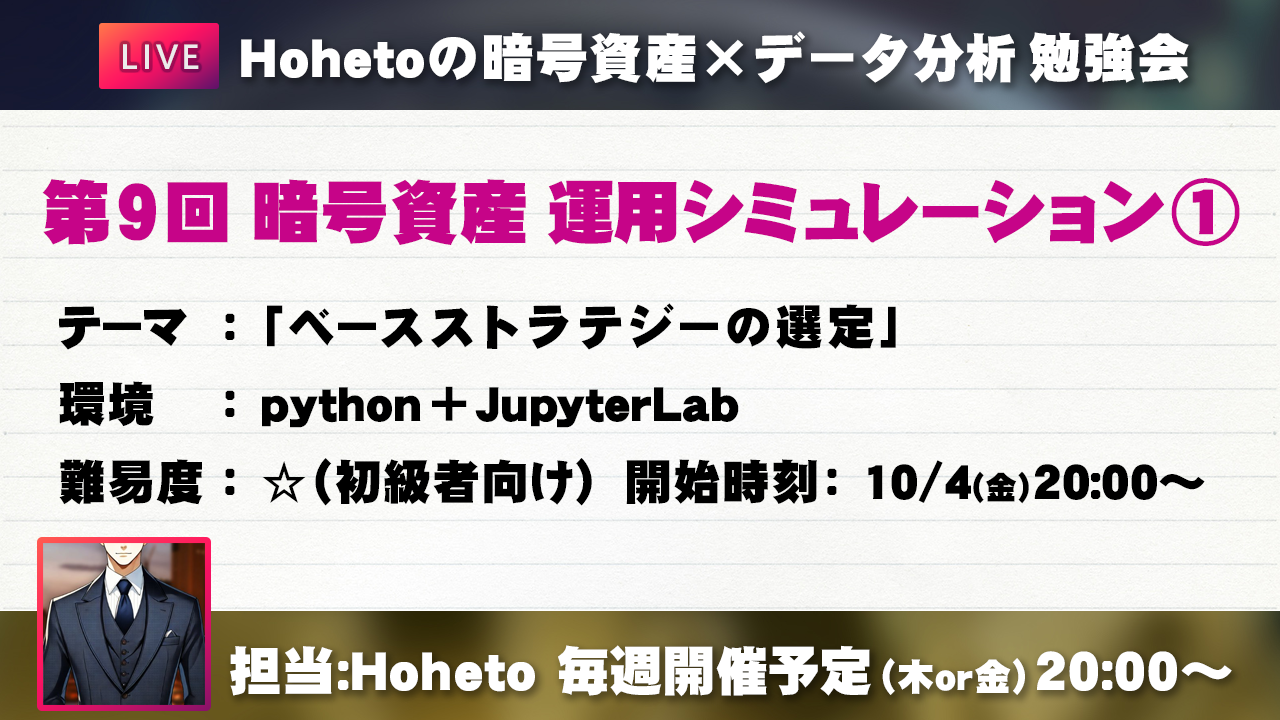

In [1]:
from IPython.display import Image

Image('./images/09_00.png')

# Hoheto勉強会 第9回 暗号資産 運用シミュレーション①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- これまでの勉強会で出てきた戦略を実際の運用に乗せます（シミュレーション）

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 運用シミュレーション

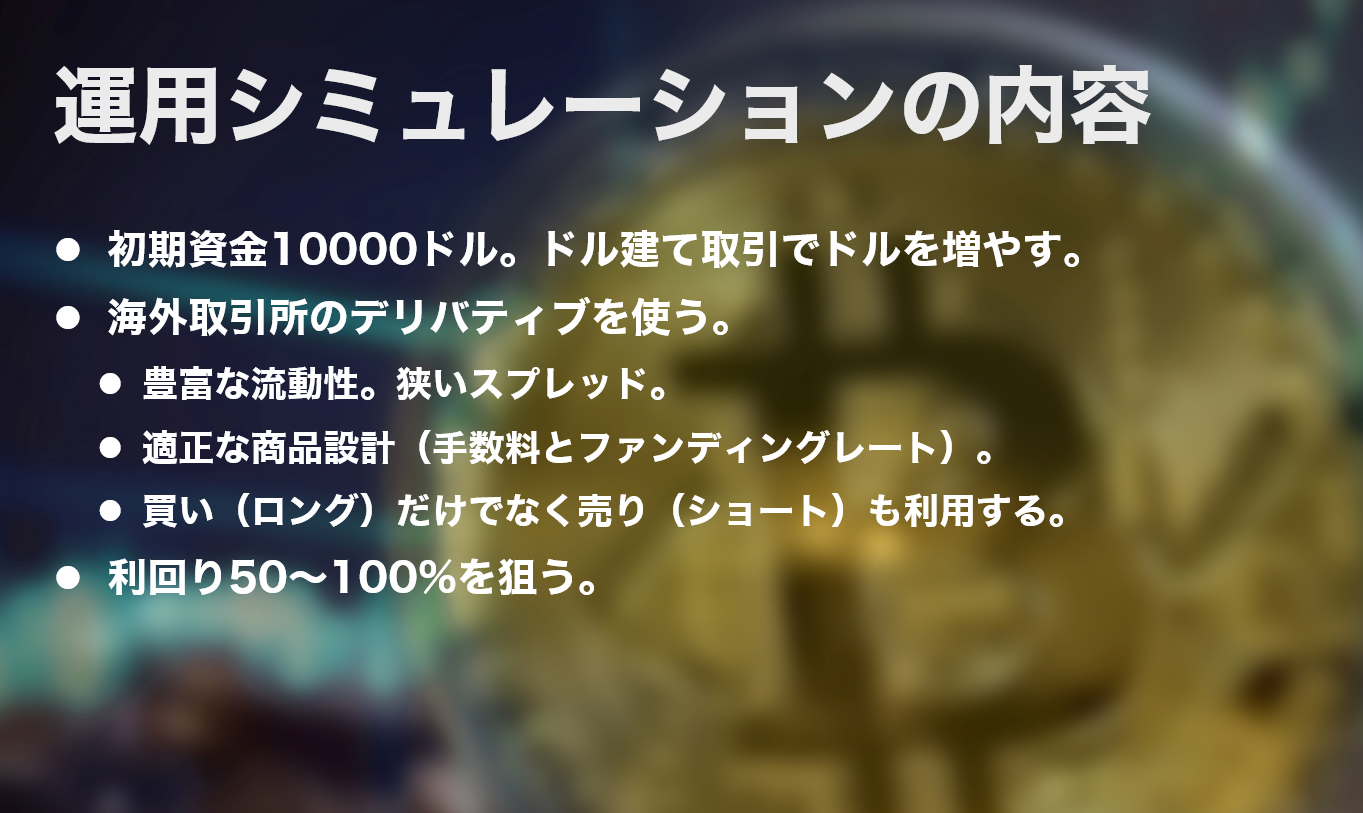

In [4]:
Image('./images/09_01.png', width=1000)

- 方針
  - とりあえず開始する。最悪失うことを覚悟する。
  - まずは低レバで動かすベース戦略をこれまでのものから選択する。
  - 後からベース戦略としての別の戦略を導入する可能性あり（分散効果を期待）。その場合は全体でベース戦略のレバレッジを調整する。
  - ベース戦略とは別に、良さそうな戦略が出てきたら2階建てで運用する。

- 資金管理
  - ロスカットを絶対に避ける。ほぼ確実にロスカットされないようにレバレッジを調整する。
  - 基本的に利確・損切りは入れない。指標に殉ずる

- ご注意！
  - 運用はあくまで自己責任でお願いします。
  - そのまま実取引できるコードはあえて掲載しません。
  - また、日本未認可の取引所を使うことはリスクを高めます。資金が守られない可能性を念頭に置く必要があります。

# これまでの勉強会の内容

## 第1回 タイムゾーンごとの値動き分析①

- 米国時間において、
  - 過去7日間の上昇日数-下落日数 >= 3 でロング
  - 過去7日間の上昇日数-下落日数 <= -3 でショート
  - それ以外はノーポジ

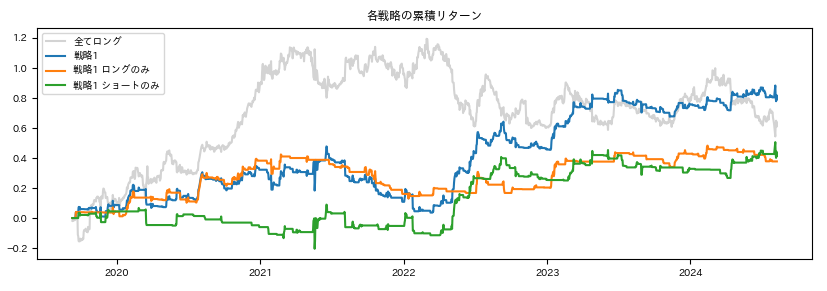

In [5]:
Image('./images/09_02.png')

## 第2回 長期積み立て戦略の検討①

- 積み立てなので対象外。

## 第3回 恐怖指数の使いどころ

- トレンドフォロー的に使う
  - Fear と Extreme Fearの間はショート
  - Greed と Extreme Greedの間はロング
  - Normal はその時点のポジションをキープ

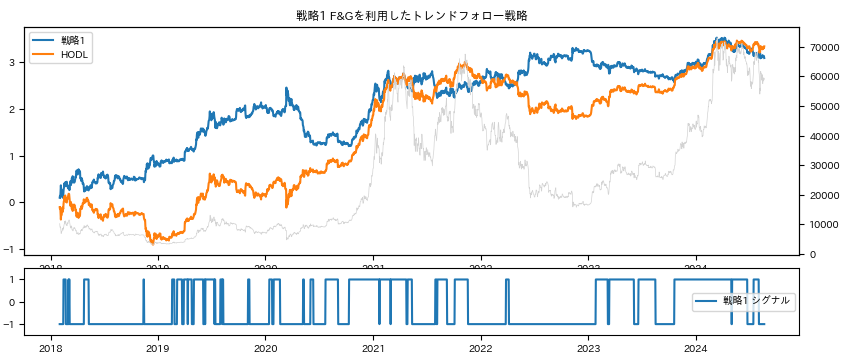

In [6]:
Image('./images/09_03.png')

## 第4回 価格系列の自己相関①

- トレンドを利用した戦略
  - 直近30日間の累積リターンがプラスなら次の日ロング、マイナスなら次の日ショート。

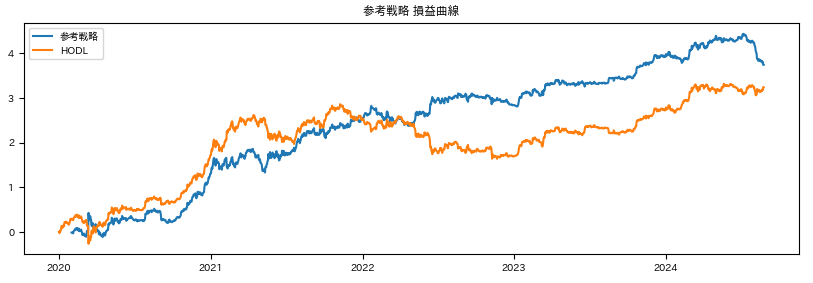

In [7]:
Image('./images/09_04.png')

## 第5回 異常検出の方法①

- 戦略は登場せず

## 第6回 ビットコインETFの分析①

- 比較的早く出揃うGBTC、ARKB、BITBのラグ1、およびIBITのラグ2を使って、ロング or ショート。

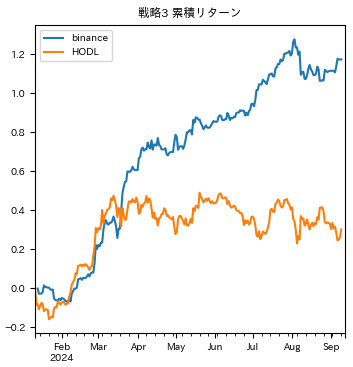

In [8]:
Image('./images/09_05.png')

## 第7回 取引所間の価格乖離の分析①

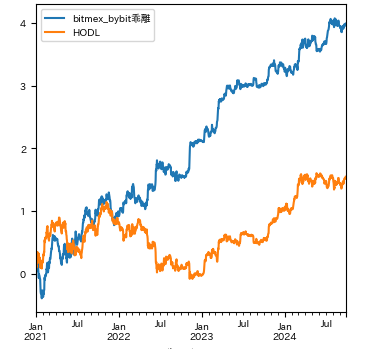

In [9]:
Image('./images/09_06.png')

## 第8回 取引所の貸出し金利の分析①

- BTC金利（標準化）を利用して、単純なロング or ショートの戦略を作ってみる。
  - 指標がプラスならロング、マイナスならショート。

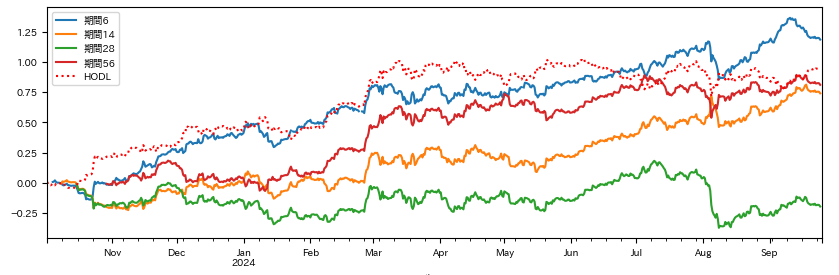

In [10]:
Image('./images/09_07.png')

## 方針

- 以下の2つをとりあえずの候補とする
  - 本命　取引所間価格乖離
  - 次点　価格系列の自己相関（トレンドフォロー）
- ETFは今回は見送り。
  - ETFは生まれて間もない。構造変化が起こる可能性がある（実際、1～4月と直近ですでに傾向が変わっている）。

# 環境設定

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [13]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データ取得

In [14]:
apis = {
    'bitmex': ccxt.bitmex(),
    'binance': ccxt.binanceusdm(),
    'bybit': ccxt.bybit(),
    'coinbase': ccxt.coinbase(),
}

In [15]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        api = apis[exchange]
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        # print(f'{datetime.fromtimestamp(ohlcv[-1][0] / 1000)}')
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'log', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df = df[from_date:to_date]
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

- 相関をプロットする関数

In [16]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

In [17]:
from_date = '2021-01-01'
to_date = '2024-10-01'

- OHLCV取得

In [18]:
ohlcv = {}

In [19]:
ohlcv['bitmex'] = fetch_ohlcv('bitmex', 'XBTUSD', from_date, to_date, '1d')
ohlcv['bitmex']['bitmex_volume'] = ohlcv['bitmex']['bitmex_volume'] / ohlcv['bitmex']['bitmex_close']

In [20]:
ohlcv['coinbase'] = fetch_ohlcv('coinbase', 'BTC/USD', from_date, to_date, '1d')

In [21]:
ohlcv['binance'] = fetch_ohlcv('binance', 'BTC/USDT:USDT', from_date, to_date, '1d')

In [22]:
ohlcv['bybit'] = fetch_ohlcv('bybit', 'BTC/USDT:USDT', from_date, to_date, '1d')

- nullチェック
  - 問題なし。

In [23]:
for exchange, df in ohlcv.items():
    if df.isnull().any().sum() == 0:
        print(f'{exchange:10} nullなし')
    else:
        print(f'{exchange:10} nullあり')
    

bitmex     nullなし
coinbase   nullなし
binance    nullなし
bybit      nullなし


- 件数、インデックス比較
  - 問題なし。

In [24]:
for exchange, df in ohlcv.items():
    print(f'{exchange:10} {len(df)}件, {df.index.min()} - {df.index.max()}')


bitmex     1370件, 2021-01-01 00:00:00+00:00 - 2024-10-01 00:00:00+00:00
coinbase   1370件, 2021-01-01 00:00:00+00:00 - 2024-10-01 00:00:00+00:00
binance    1370件, 2021-01-01 00:00:00+00:00 - 2024-10-01 00:00:00+00:00
bybit      1370件, 2021-01-01 00:00:00+00:00 - 2024-10-01 00:00:00+00:00


# 戦略作成

- 手数料＋コスト
  - ポジションを1単位作る際のコストを10bpに想定。
  - 参考 Binance USDM テイカー5bp。bybit 無期限 テイカー5.5bp

In [25]:
fee = 0.001

In [26]:
strategy = ohlcv['binance'].copy()
strategy['ror'] = (strategy['binance_close'] - strategy['binance_open']) / strategy['binance_open']
strategy['bitmex_close'] = ohlcv['bitmex']['bitmex_close']
strategy['coinbase_close'] = ohlcv['coinbase']['coinbase_close']
strategy['bybit_close'] = ohlcv['bybit']['bybit_close']
strategy['bitmex_binance_dev'] = strategy['bitmex_close'] / strategy['binance_close'] - 1
strategy['bitmex_bybit_dev'] = strategy['bitmex_close'] / strategy['bybit_close'] - 1
strategy['coinbase_binance_dev'] = strategy['coinbase_close'] / strategy['binance_close'] - 1
strategy['coinbase_bybit_dev'] = strategy['coinbase_close'] / strategy['bybit_close'] - 1

## 戦略のおさらい

- ①BitMEX-Binance乖離がプラスならロング、マイナスならショート。
- ②BitMEX-bybit乖離　　〃
- ③Coinbase-Binance乖離　　〃
- ④Coinbase-bybit乖離　　〃

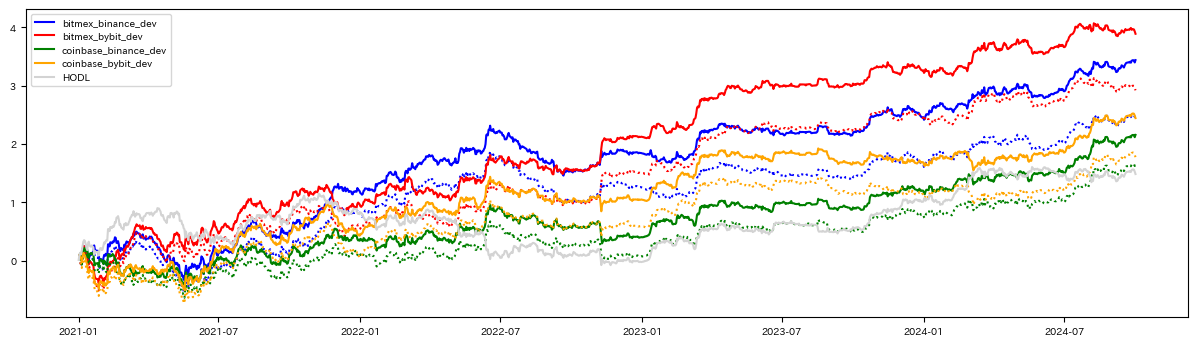

In [27]:
plt.figure(figsize=(15, 4))

strategy['signal'] = np.sign(strategy['bitmex_binance_dev'].shift(1))
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
plt.plot(strategy['pnl'].cumsum(), color='blue', label='bitmex_binance_dev')
plt.plot((strategy['pnl'] - strategy['fee']).cumsum(), color='blue', linestyle='dotted')

strategy['signal'] = np.sign(strategy['bitmex_bybit_dev'].shift(1))
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
plt.plot(strategy['pnl'].cumsum(), color='red', label='bitmex_bybit_dev')
plt.plot((strategy['pnl'] - strategy['fee']).cumsum(), color='red', linestyle='dotted')

strategy['signal'] = np.sign(strategy['coinbase_binance_dev'].shift(1))
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
plt.plot(strategy['pnl'].cumsum(), color='green', label='coinbase_binance_dev')
plt.plot((strategy['pnl'] - strategy['fee']).cumsum(), color='green', linestyle='dotted')

strategy['signal'] = np.sign(strategy['coinbase_bybit_dev'].shift(1))
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
plt.plot(strategy['pnl'].cumsum(), color='orange', label='coinbase_bybit_dev')
plt.plot((strategy['pnl'] - strategy['fee']).cumsum(), color='orange', linestyle='dotted')

plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.legend();

- これをもとに、ベースストラテジーを作成する。

## 指標の内容チェック

- 全体として平均はゼロよりやや上。これはUSDTのリスクを反映しているものと思われる（通常時はUSD>USDT）。
- しかし概ねゼロに収束している。

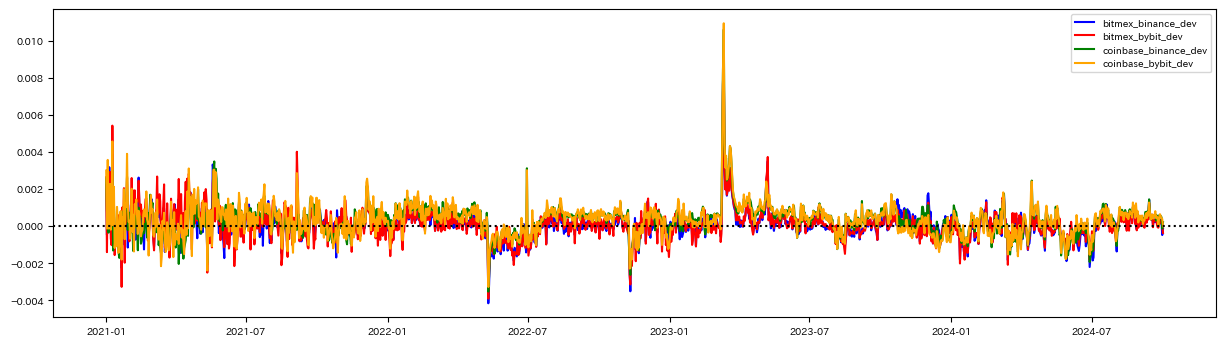

In [28]:
plt.figure(figsize=(15, 4))
plt.plot(strategy['bitmex_binance_dev'], label='bitmex_binance_dev', color='blue')
plt.plot(strategy['bitmex_bybit_dev'], label='bitmex_bybit_dev', color='red')
plt.plot(strategy['coinbase_binance_dev'], label='coinbase_binance_dev', color='green')
plt.plot(strategy['coinbase_bybit_dev'], label='coinbase_bybit_dev', color='orange')
plt.axhline(0, color='k', linestyle=':')
plt.legend();

- 各乖離とリターンとの相関
  - BitMEXに絡む乖離がやや強い。

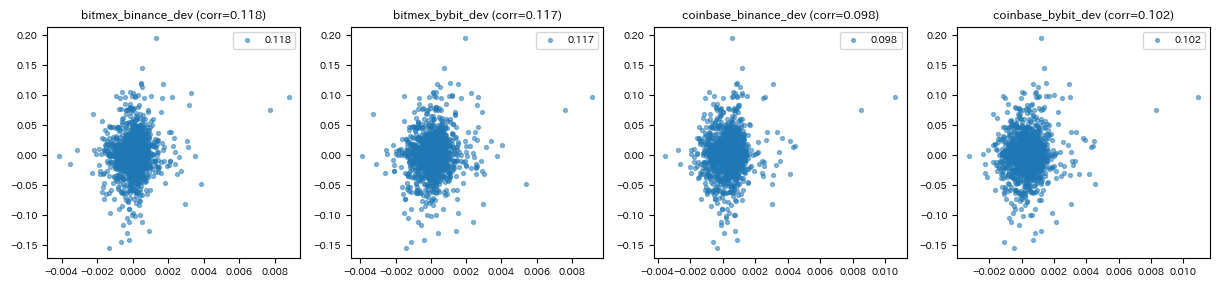

In [29]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 4, 1)
plot_corr(strategy['bitmex_binance_dev'].shift(1), strategy['ror'], title='bitmex_binance_dev')
plt.subplot(1, 4, 2)
plot_corr(strategy['bitmex_bybit_dev'].shift(1), strategy['ror'], title='bitmex_bybit_dev')
plt.subplot(1, 4, 3)
plot_corr(strategy['coinbase_binance_dev'].shift(1), strategy['ror'], title='coinbase_binance_dev')
plt.subplot(1, 4, 4)
plot_corr(strategy['coinbase_bybit_dev'].shift(1), strategy['ror'], title='coinbase_bybit_dev');

- ローリング相関
  - どの乖離も概ね似た推移となっている（効く時期、効かない時期がある）
  - しかし数年前と現在で大きな違いはないように見受けられる。

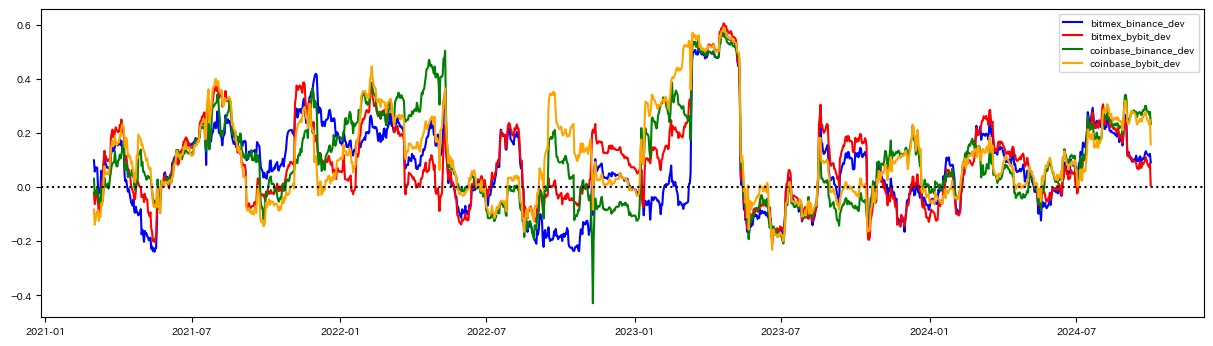

In [30]:
plt.figure(figsize=(15, 4))
plt.plot(strategy['bitmex_binance_dev'].shift(1).rolling(60).corr(strategy['ror']), label='bitmex_binance_dev', color='blue')
plt.plot(strategy['bitmex_bybit_dev'].shift(1).rolling(60).corr(strategy['ror']), label='bitmex_bybit_dev', color='red')
plt.plot(strategy['coinbase_binance_dev'].shift(1).rolling(60).corr(strategy['ror']), label='coinbase_binance_dev', color='green')
plt.plot(strategy['coinbase_bybit_dev'].shift(1).rolling(60).corr(strategy['ror']), label='coinbase_bybit_dev', color='orange')
plt.axhline(0, color='k', linestyle=':')
plt.legend();

- 指標同士の相関
  - 相関は強いが多少バラつきはある。

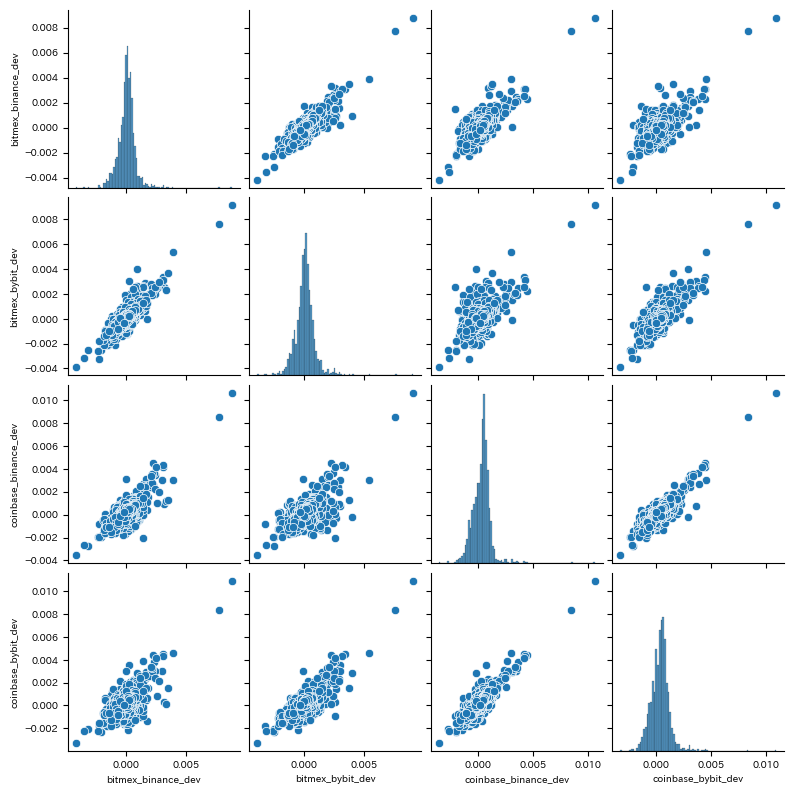

In [31]:
sns.pairplot(strategy.filter(regex='_dev$'), height=2)

- 定常性チェック
  - 定常性とは、時期に応じて平均や分散が変化しないことを指す。
  - もしも定常性がなければ（時期に応じて平均や分散が異なれば）、現在効いている指標も将来的に効かなくなったり意味が変わったりする。
  - 系列データが定常かどうかは検定する手法がある（ADF検定）。

In [32]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    statistic = result[0]
    p_value = result[1]
    print(f'p-value: {p_value:.4f} (ADF Statistic: {statistic:.4f})')

- 例えば、価格系列は定常ではない(p値が0.05以下、あるいは0.01以下で定常とみなす)。

In [33]:
adf_test(strategy['binance_close'])

p-value: 0.6174 (ADF Statistic: -1.3256)


- リターンに変換（あるいは対数変換）すると定常性が出るので、ファイナンス時系列モデル構築の際はリターン系列を作るのが基本となる。

In [34]:
adf_test(strategy['ror'])

p-value: 0.0000 (ADF Statistic: -38.4878)


- 各乖離指標は・・・

In [35]:
adf_test(strategy['bitmex_binance_dev'])

p-value: 0.0000 (ADF Statistic: -7.5687)


In [36]:
adf_test(strategy['bitmex_bybit_dev'])

p-value: 0.0000 (ADF Statistic: -7.3467)


In [37]:
adf_test(strategy['coinbase_binance_dev'])

p-value: 0.0000 (ADF Statistic: -7.1148)


In [38]:
adf_test(strategy['coinbase_bybit_dev'])

p-value: 0.0001 (ADF Statistic: -4.5717)


- 指標はすべて定常といえそう。

## さあどうする

- これらの乖離を特徴量エンジニアリング的にこねくりまわす
- シンプルなモデル（線形モデルなど）を使って1つの指標を出す
- そのまま使って多数決を取る

- 例えば・・・

- bitmex_bybit乖離ラグ1 + bitmex_bybit乖離ラグ2 + bitmex_binance乖離ラグ1 + coinbase_bybit乖離ラグ2
- <font color="red">損益曲線を見ながらの調整は絶対にやってはいけない</font>

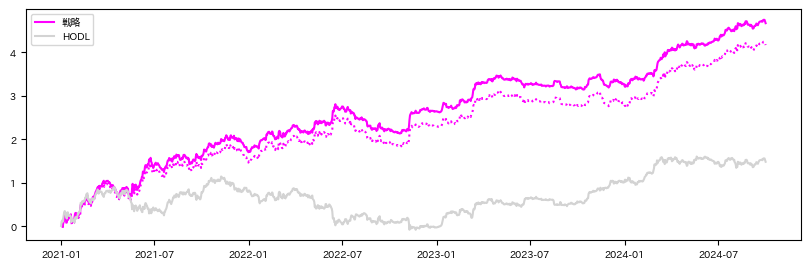

In [39]:
strategy['signal'] = np.sign((strategy['bitmex_bybit_dev'] + strategy['bitmex_binance_dev'] + strategy['bitmex_bybit_dev'].shift(1) + strategy['coinbase_bybit_dev'].shift(1)).shift(1))
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
plt.figure(figsize=(10, 3))
plt.plot(strategy['pnl'].cumsum(), label='戦略', color='magenta')
plt.plot((strategy['pnl'] - strategy['fee']).cumsum(), color='magenta', linestyle=':')
plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.legend();

- なるべく単純な戦略でいく。
- ノイズの大きい金融時系列ではシグナルの組み合わせが有効。単純に組み合わせる方向で行く。

- ①シグナルを加算した結果に対して、符号を取る

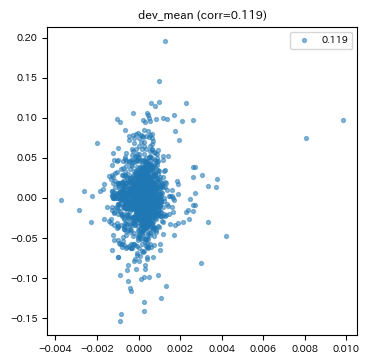

In [40]:
strategy['dev_mean'] = (strategy['bitmex_binance_dev'] + strategy['bitmex_bybit_dev'] + strategy['coinbase_binance_dev'] + strategy['coinbase_bybit_dev']).shift(1) / 4
plot_corr(strategy['dev_mean'], strategy['ror'], title='dev_mean');

- リターン相関は若干高くなる程度。
- 外れ値の影響を抑える効果を見込める。

SR(daily): 0.05907
SR(yearly): 1.12857
最大DD: 0.71821


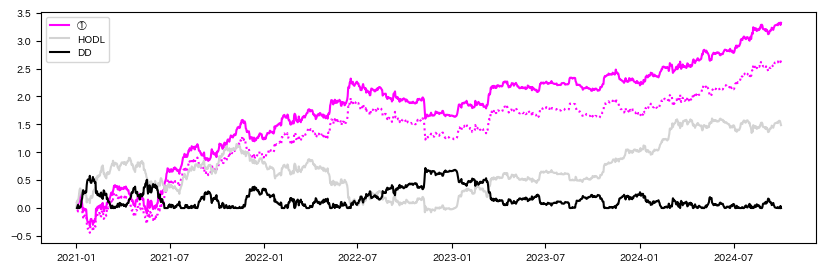

In [41]:
strategy['signal'] = np.sign(strategy['dev_mean'])
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
strategy['pnl_with_fee'] = strategy['pnl'] - strategy['fee']
strategy['dd'] = strategy['pnl'].cumsum().cummax() - strategy['pnl'].cumsum()
plt.figure(figsize=(10, 3))
plt.plot(strategy['pnl'].cumsum(), label='①', color='magenta')
plt.plot(strategy['pnl_with_fee'].cumsum(), color='magenta', linestyle=':')
plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.plot(strategy['dd'], label='DD', color='k')
plt.legend();
sr_daily = strategy["pnl_with_fee"].mean()/strategy["pnl_with_fee"].std()
sr_anual = sr_daily * np.sqrt(365)
print(f'SR(daily): {sr_daily:.5f}')
print(f'SR(yearly): {sr_anual:.5f}')
print(f'最大DD: {strategy["dd"].max():.5f}')

- ②それぞれの符号を取ったあと、足し合わせる
  - それぞれの指標の外れ値が符号化により切り捨てられてそれが足し合わされる→さらに外れ値やノイズの影響を抑える効果が見込める。

- DDが下がりSRが改善。

SR(daily): 0.06688
SR(yearly): 1.27782
最大DD: 0.57513


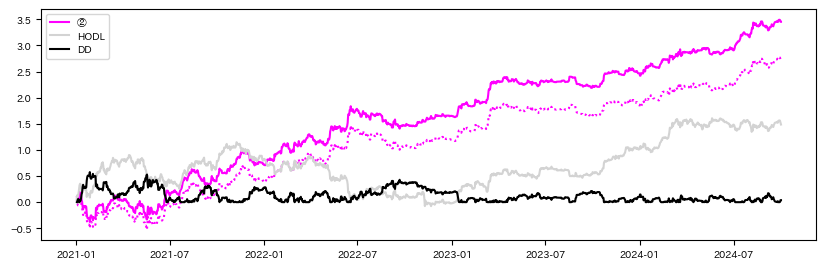

In [42]:
strategy['signal'] = np.sign(strategy['bitmex_binance_dev'].shift(1)) + np.sign(strategy['bitmex_bybit_dev'].shift(1)) + np.sign(strategy['coinbase_binance_dev'].shift(1)) + np.sign(strategy['coinbase_bybit_dev'].shift(1))
strategy['signal'] = np.sign(strategy['signal'])
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
strategy['pnl_with_fee'] = strategy['pnl'] - strategy['fee']
strategy['dd'] = strategy['pnl'].cumsum().cummax() - strategy['pnl'].cumsum()
plt.figure(figsize=(10, 3))
plt.plot(strategy['pnl'].cumsum(), label='②', color='magenta')
plt.plot(strategy['pnl_with_fee'].cumsum(), color='magenta', linestyle=':')
plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.plot(strategy['dd'], label='DD', color='k')
plt.legend();
sr_daily = strategy["pnl_with_fee"].mean()/strategy["pnl_with_fee"].std()
sr_anual = sr_daily * np.sqrt(365)
print(f'SR(daily): {sr_daily:.5f}')
print(f'SR(yearly): {sr_anual:.5f}')
print(f'最大DD: {strategy["dd"].max():.5f}')

- 上記どちらかを選択したい。

## ポジションサイズを決める

- パターン１
- 指標とリターンに相関が認められるということは、シグナルが強いほうが勝率が高くなる。

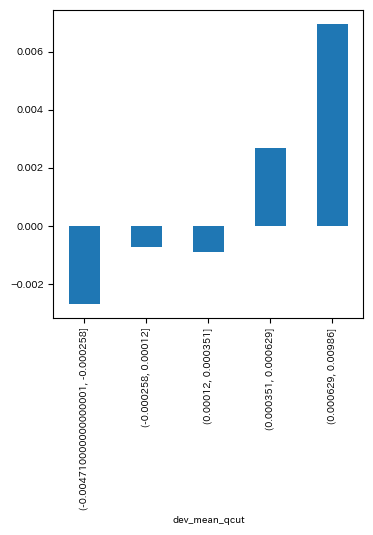

In [43]:
strategy['dev_mean_qcut'] = pd.qcut(strategy['dev_mean'], q=5)
strategy.groupby('dev_mean_qcut')['ror'].mean().plot(kind='bar');

- 指標が大きいときにポジションを大きく、小さいときはポジションを小さくする。

signal
 0.5    537
 1.0    381
-0.5    261
-1.0    190
 0.0      1
Name: count, dtype: int64
SR(daily): 0.08061
SR(yearly): 1.54009
最大DD: 0.44448


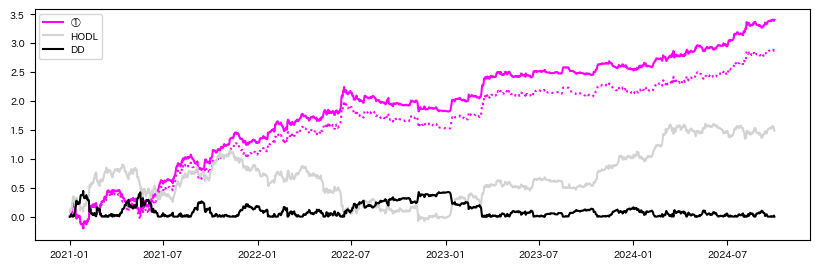

In [44]:
strategy['signal'] = 0
strategy.loc[(strategy['dev_mean'] < 0.000), 'signal'] = -0.5
strategy.loc[(strategy['dev_mean'] < -0.0005), 'signal'] = -1.0
strategy.loc[(strategy['dev_mean'] > 0.000), 'signal'] = 0.5
strategy.loc[(strategy['dev_mean'] > 0.0005), 'signal'] = 1.0
print(strategy['signal'].value_counts())
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
strategy['pnl_with_fee'] = strategy['pnl'] - strategy['fee']
strategy['dd'] = strategy['pnl'].cumsum().cummax() - strategy['pnl'].cumsum()
plt.figure(figsize=(10, 3))
plt.plot(strategy['pnl'].cumsum(), label='①', color='magenta')
plt.plot(strategy['pnl_with_fee'].cumsum(), color='magenta', linestyle=':')
plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.plot(strategy['dd'], label='DD', color='k')
plt.legend();
sr_daily = strategy["pnl_with_fee"].mean()/strategy["pnl_with_fee"].std()
sr_anual = sr_daily * np.sqrt(365)
print(f'SR(daily): {sr_daily:.5f}')
print(f'SR(yearly): {sr_anual:.5f}')
print(f'最大DD: {strategy["dd"].max():.5f}')

- パターン２
- 多数決で票が偏ったとき、ポジションを多くする。
  - 4票差　→　MAXポジション
  - 2票差　→　1/2ポジション
  - 0票差　→　0

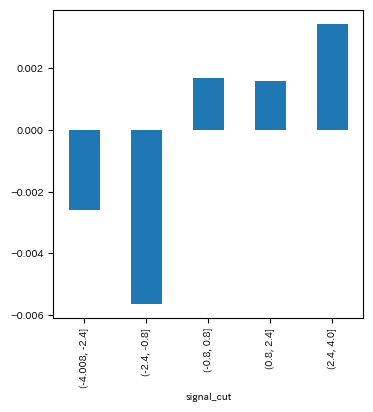

In [45]:
strategy['signal'] = np.sign(strategy['bitmex_binance_dev'].shift(1)) + np.sign(strategy['bitmex_bybit_dev'].shift(1)) + np.sign(strategy['coinbase_binance_dev'].shift(1)) + np.sign(strategy['coinbase_bybit_dev'].shift(1))
strategy['signal_cut'] = pd.cut(strategy['signal'], bins=5)
strategy.groupby('signal_cut')['ror'].mean().plot(kind='bar');

SR(daily): 0.06201
SR(yearly): 1.18479
最大DD: 0.51504


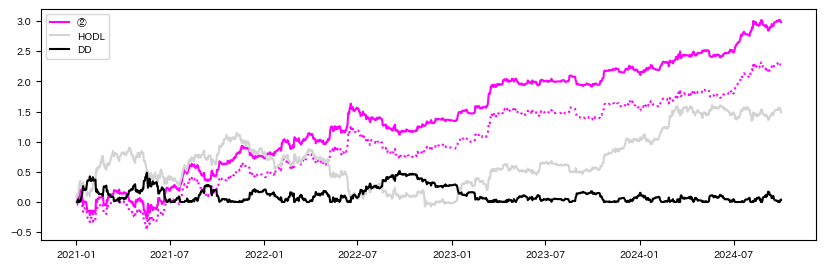

In [46]:
strategy['signal'] = np.sign(strategy['bitmex_binance_dev'].shift(1)) + np.sign(strategy['bitmex_bybit_dev'].shift(1)) + np.sign(strategy['coinbase_binance_dev'].shift(1)) + np.sign(strategy['coinbase_bybit_dev'].shift(1))
strategy['signal'] = strategy['signal'] / 4
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
strategy['pnl_with_fee'] = strategy['pnl'] - strategy['fee']
strategy['dd'] = strategy['pnl'].cumsum().cummax() - strategy['pnl'].cumsum()
plt.figure(figsize=(10, 3))
plt.plot(strategy['pnl'].cumsum(), label='②', color='magenta')
plt.plot(strategy['pnl_with_fee'].cumsum(), color='magenta', linestyle=':')
plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.plot(strategy['dd'], label='DD', color='k')
plt.legend();
sr_daily = strategy["pnl_with_fee"].mean()/strategy["pnl_with_fee"].std()
sr_anual = sr_daily * np.sqrt(365)
print(f'SR(daily): {sr_daily:.5f}')
print(f'SR(yearly): {sr_anual:.5f}')
print(f'最大DD: {strategy["dd"].max():.5f}')

# まとめ

- パターン①で運用シミュレーションを行う。
- 最大DDは0.44。最大レバレッジは1倍でいく。
- 今後、実装します。YouTube上ではシミュレーション結果として追っていきます。
- 運用に値するストラテジーが今後できた場合、追加していきます。

# 残りのトピック

- バックテスト構築 -> 別途やります
- 執行方法
- コスト
  - 未約定・部分約定コスト
  - シミュレーションと運用の間の乖離をウォッチする。
  - ファンディングコストの見積もり
- システムストップについて

# 次回

- YouTubeチャンネル開設後2ヶ月経過
- UKIと振り返りのライブをやる予定です。